# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 874, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 874, 14)
Extracting parameters from /home/davidcalhas/eeg

In [5]:
n_ica_components = 20

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)


n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)

tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=n_ica_components)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

### Train the network

In [ ]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)

def cosine_loss(outputs, targets):
    return tf.keras.backend.mean(-losses.correlation_angle([outputs, targets]))

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_voxel_loss,
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target)

model_name = "LComb"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Encoder Loss:  0.37462103  || Decoder Loss:  -0.3700805 Validation Decoder Loss:  -1.068309
Encoder Loss:  0.42895594  || Decoder Loss:  -0.4954587 Validation Decoder Loss:  -1.3052776
Encoder Loss:  0.471635  || Decoder Loss:  -0.5878435 Validation Decoder Loss:  -1.4457574
Encoder Loss:  0.49166104  || Decoder Loss:  -0.6255918 Validation Decoder Loss:  -1.4668493
Encoder Loss:  0.49950883  || Decoder Loss:  -0.64091647 Validation Decoder Loss:  -1.4916269
Encoder Loss:  0.5414812  || Decoder Loss:  -0.71162945 Validation Decoder Loss:  -3.051497


train set mean:  -0.3039120972383812
train set std:  0.28774007266367735
validation set mean:  -1.4218038065092904
validation set std:  0.030337234429490115
test set mean:  -1.4298323478017534
test set std:  0.03069248499282121


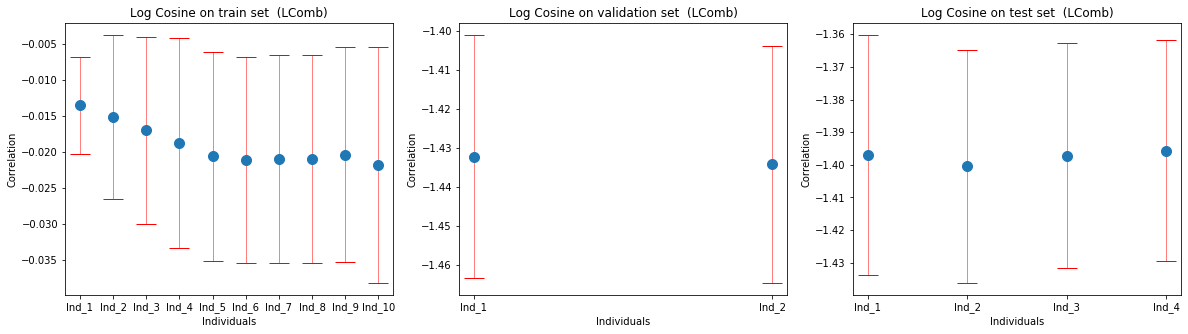

train set mean:  0.2339286807255121
train set std:  0.1903562279797835
validation set mean:  0.7586094992501395
validation set std:  0.007426288686472221
test set mean:  0.7605363244102115
test set std:  0.007533821919061613


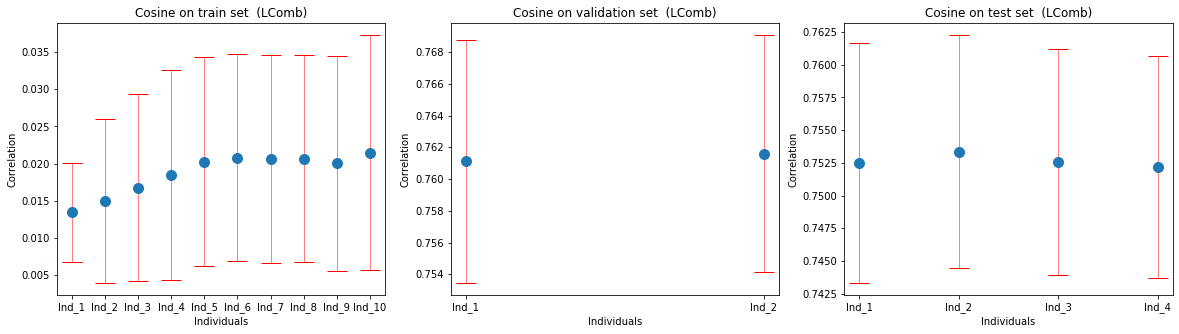

train set mean:  281.0472083682106
train set std:  60.8644738853916
validation set mean:  2133.9170503162204
validation set std:  3.8194806712616107
test set mean:  2131.897179013207
test set std:  7.0357415246882615


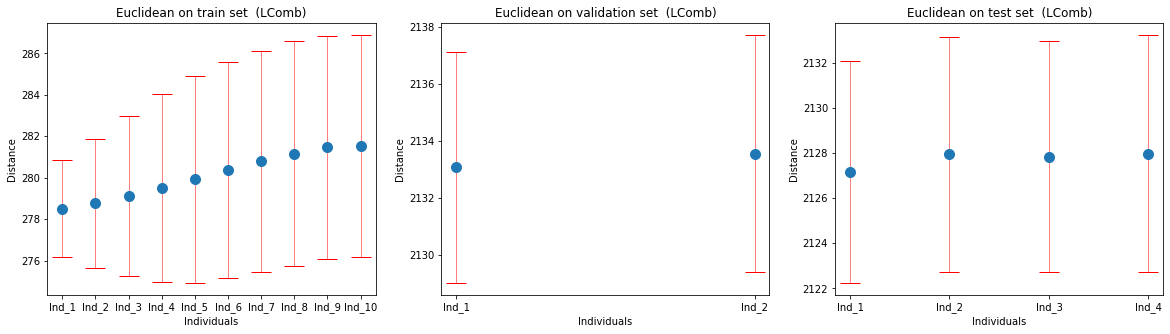

In [19]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [5]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                     X_train_bold, 
                     auto_encoder_model, 
                     epochs=40, 
                     auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                     batch_size=batch_size, 
                     X_val_eeg=eeg_val, 
                     X_val_bold=bold_val)

model_name = "AE"

Autoencoder Loss:  -0.095452726 || Validation Autoencoder Loss:  -0.22881204
Autoencoder Loss:  -0.41205734 || Validation Autoencoder Loss:  -0.06433905
Autoencoder Loss:  -0.67522085 || Validation Autoencoder Loss:  -0.06027302
Autoencoder Loss:  -0.714125 || Validation Autoencoder Loss:  -0.059752088
Autoencoder Loss:  -0.7236493 || Validation Autoencoder Loss:  -0.054856524
Autoencoder Loss:  -0.7281843 || Validation Autoencoder Loss:  -0.053730927
Autoencoder Loss:  -0.7311284 || Validation Autoencoder Loss:  -0.052539643
Autoencoder Loss:  -0.7332041 || Validation Autoencoder Loss:  -0.051364098
Autoencoder Loss:  -0.73475933 || Validation Autoencoder Loss:  -0.05061001
Autoencoder Loss:  -0.73592377 || Validation Autoencoder Loss:  -0.05011139
Autoencoder Loss:  -0.7368238 || Validation Autoencoder Loss:  -0.049732037
Autoencoder Loss:  -0.73754215 || Validation Autoencoder Loss:  -0.04940387
Autoencoder Loss:  -0.73811144 || Validation Autoencoder Loss:  -0.04904201
Autoencoder 

train set mean:  -0.13311006072955933
train set std:  0.2449961366964031
validation set mean:  -0.04463356371561531
validation set std:  0.03384605111646344
test set mean:  -0.03746132824322558
test set std:  0.017526394748616832


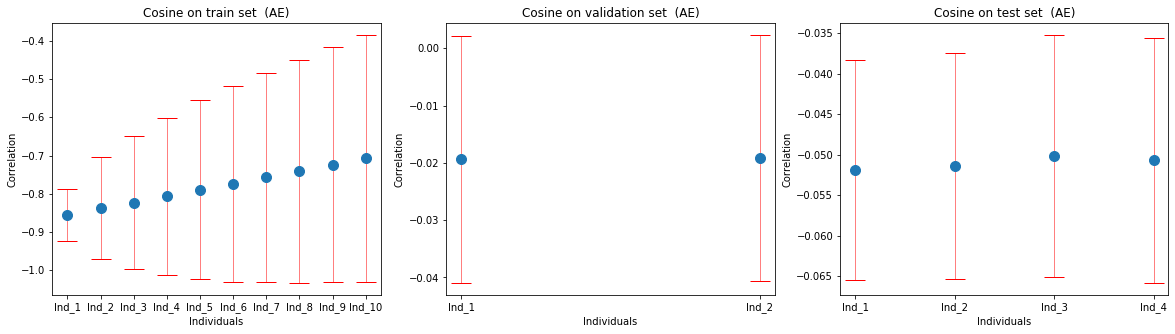

train set mean:  1142.1080750732422
train set std:  551.4886067627078
validation set mean:  1659.0252697753906
validation set std:  357.8917398773506
test set mean:  2456.652622680664
test set std:  2650.773306452326


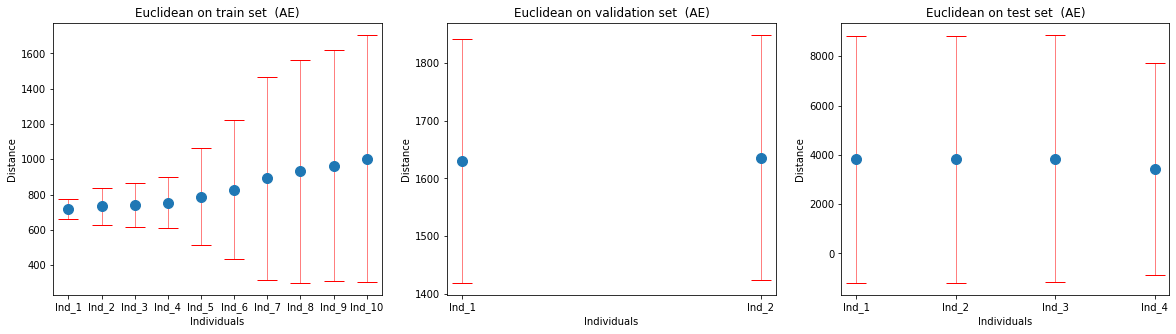

In [6]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [3]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       g_loss_function=losses.loss_wasserstein_generator,
                                                       d_loss_function=losses.loss_wasserstein_discriminator,
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

model_name = "GAN"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
GAN Encoder Loss:  -0.28991166  || GAN Decoder Loss:  -0.39365986  || GAN Validation Decoder Loss:  -0.28331986  || Train Reconstruction Loss:  -0.045067016  || Validation Reconstruction Loss:  -0.28331986
GAN Encoder Loss:  -0.43405125  || GAN Decoder Loss:  -0.4922337  || GAN Validation Decoder Loss:  -0.20242985  || Train Reconstruction Loss:  -0.071308285  || Validation Reconstruction Loss:  -0.20242988
GAN Encoder Loss:  -0.44488975  || GAN Decoder Loss:  -0.49787426  || GAN Validation Decoder Loss:  -0.086065084  || Train Reconstruction Loss:  -0.012954713  || Validation Reconstruction Loss:  -0.086065084
GAN Encoder Loss:  -0.45309806  || GAN Decoder Loss:  -0.4979163  || GAN Validation Decoder Loss:  -0.19741003  || Train Reconstruction Loss:  -0.011427431  || Validation Reconstruction Loss:  -0.19741003
GAN Encoder Loss:  -0.45764676  || GAN Decoder Loss:  -0.4975327  || GAN Validatio

GAN Encoder Loss:  -0.44628027  || GAN Decoder Loss:  -0.49883553  || GAN Validation Decoder Loss:  -0.0142966425  || Train Reconstruction Loss:  -0.0033892107  || Validation Reconstruction Loss:  -0.014296644


train set mean:  -0.009127632046693179
train set std:  0.007466760577828447
validation set mean:  -0.015903630449902267
validation set std:  0.009820024460421841
test set mean:  -0.01502398014847131
test set std:  0.00845396371582886


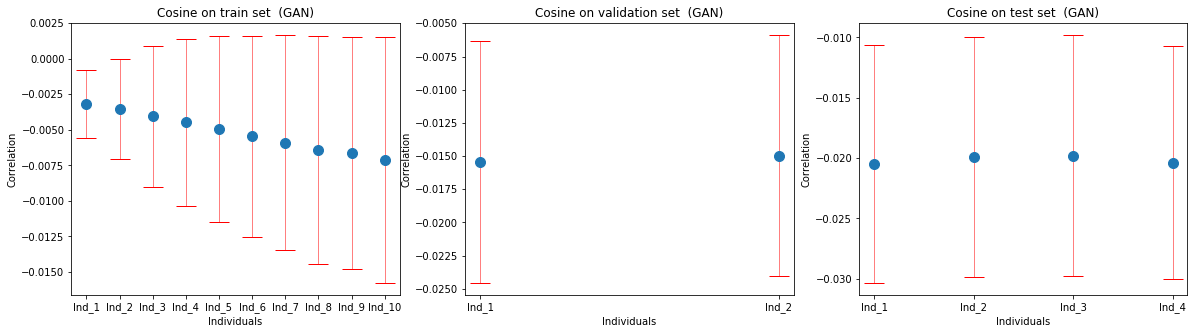

train set mean:  135404.0415703125
train set std:  96438.4454589708
validation set mean:  136103.474375
validation set std:  83729.00962358619
test set mean:  198427.6971875
test set std:  89124.63566672752


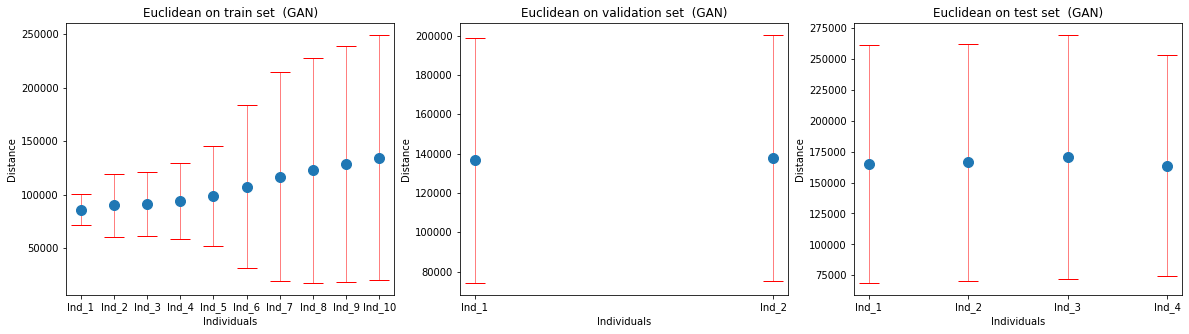

In [4]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [30]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

Encoder Loss:  0.118197516  || Decoder Loss:  -0.10892728 Validation Decoder Loss:  -0.34396172
Encoder Loss:  0.17350961  || Decoder Loss:  -0.21215793 Validation Decoder Loss:  -0.417525
Encoder Loss:  0.17483221  || Decoder Loss:  -0.21957809 Validation Decoder Loss:  -0.42274988
Encoder Loss:  0.17368379  || Decoder Loss:  -0.22170837 Validation Decoder Loss:  -0.42290154
Encoder Loss:  0.17259873  || Decoder Loss:  -0.22295734 Validation Decoder Loss:  -0.42123955
GAN Encoder Loss:  1.0127182  || GAN Decoder Loss:  0.14818361  || GAN Validation Decoder Loss:  -0.7285427  || Train Reconstruction Loss:  0.083577104  || Validation Reconstruction Loss:  0.5169993
GAN Encoder Loss:  0.5068348  || GAN Decoder Loss:  0.5557646  || GAN Validation Decoder Loss:  -0.36623427  || Train Reconstruction Loss:  0.12438231  || Validation Reconstruction Loss:  0.30665627
GAN Encoder Loss:  0.24195859  || GAN Decoder Loss:  1.0542921  || GAN Validation Decoder Loss:  -0.2962604  || Train Reconstruc

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


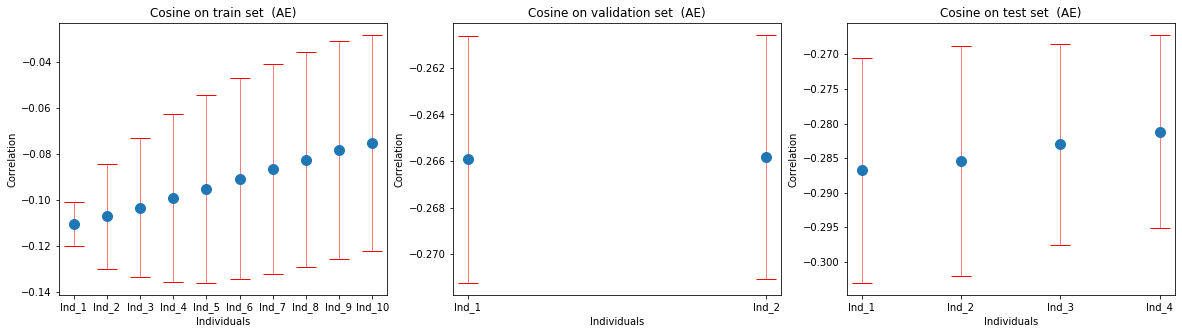

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


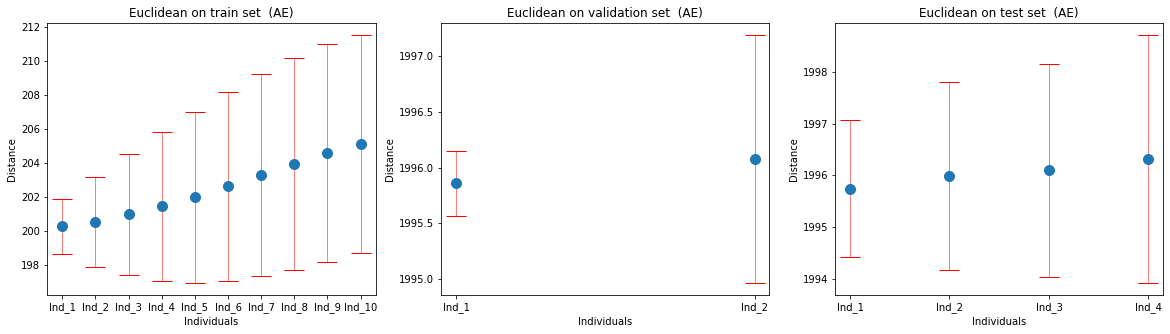

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [10]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            batch_size=batch_size, 
                                                            top_k=5, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Conv2D: Dst tensor is not initialized. [Op:Conv2D]